# Preprocess Data
Load data from file
Convert image data to [0-1] and reshape to [60000,784] (60000 is total image to training)
Convert label to one hot vector look like [0,0,1,0,0,0,0,0,0,0] corresponding to number two

Image Shape: (60000, 784)
Label shape: (60000, 10)
Image Value: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.    

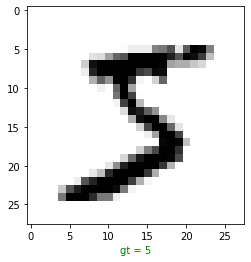

In [1]:
import random
import math
import struct
import numpy as np
from matplotlib import pyplot as plt

def read_idx(filename):
    with open(filename, 'rb') as f:
        dims = struct.unpack('>HBB', f.read(4))[2]
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))

        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)


def load_mnist(image_path, label_path):
    images = read_idx(image_path)
    labels = read_idx(label_path)
    return images, labels


# Dataset from http://yann.lecun.com/exdb/mnist/
train_images, train_labels = load_mnist('./mnist-data/train-images.idx3-ubyte',
                                        './mnist-data/train-labels.idx1-ubyte')
test_images, test_labels = load_mnist('./mnist-data/t10k-images.idx3-ubyte',
                                      './mnist-data/t10k-labels.idx1-ubyte')
train_images = np.reshape(train_images, [-1, 784]) / 255
test_images = np.reshape(test_images, [-1, 784]) / 255

n_values = np.max(train_labels) + 1
train_labels_normalize = np.eye(n_values)[train_labels]

n_values = np.max(test_labels) + 1
test_labels_normalize = np.eye(n_values)[test_labels]
print(f'Image Shape: {train_images.shape}')
print(f'Label shape: {train_labels_normalize.shape}')
print(f'Image Value: {train_images[0]}')
print(f'Label shape: {train_labels_normalize[0]}')

# show image and label
index = 0
plt.xlabel('gt = {}'.format(train_labels[index]), color = 'g')
plt.imshow(train_images[index].reshape([28,28]), cmap = 'binary')

# Util functions

In [2]:
def he_initialize(shape):
    stddev = np.sqrt(2 / shape[0])
    return np.random.randn(*shape) * stddev
def xavier_initialize(shape):
    stddev = np.sqrt(1 / shape[0])
    return np.random.randn(*shape) * stddev

# Activation sigmoid
def sigmoid(arr):
    return [1 / (1 + math.exp(-x)) for x in arr]


# Sigmoid Derivative Function
def sigmoid_derivative(arr):
    return [x * (1 - x) for x in arr]

# Activation Relu
def relu(arr):
    return [0 if x < 0 else x for x in arr]

# Relu Derivative Function
def relu_derivative(arr):
    return [1 if x > 0 else 0 for x in arr]

def softmax(x):
    max_x = max(x)
    exp_x = [math.exp(i - max_x) for i in x]
    sum_exp_x = sum(exp_x)
    return [i / sum_exp_x for i in exp_x]

def softmax_derivative(x):
    s = softmax(x)
    return [s[i] * (1 - s[i]) for i in range(len(x))]


# Mean Squared Error
def mse(outputs, targets):
    return [(o - t) ** 2 for o, t in zip(outputs, targets)]
def mse_gradient():
    return [2*(p - t) for p,t in zip(y_pred,y_true)]

def categorical_crossentropy(y_pred, y_true):
    return [-t * math.log(p) for p,t in zip(y_pred,y_true)]

def categorical_crossentropy_gradient(y_pred, y_true):
    return [p - t for p,t in zip(y_pred,y_true)]

def leaky_relu(x, alpha=0.01):
    if isinstance(x, (list, tuple, set)):
        return [leaky_relu(v, alpha) for v in x]
    elif isinstance(x, float):
        return x if x >= 0 else alpha * x
    else:
        raise TypeError("Input must be a float or a list/tuple/set of floats.")

def leaky_relu_derivative(x, alpha=0.01):

    if isinstance(x, (list, tuple, set)):
        return [leaky_relu_derivative(v, alpha) for v in x]
    elif isinstance(x, float):
        return 1 if x >= 0 else alpha
    else:
        raise TypeError("Input must be a float or a list/tuple/set of floats.")


# Return true to early stop training
def early_stopping(model, epoch, loss):
    return loss < 0.01

# Callback each training epoch
def epoch_end_callback(model, epoch, loss):
    # save model when loss is decrease
    if epoch == 0 or (epoch > 0 and loss < model.loss_history[epoch - 1]):
        model.save_model('mnist_model.any_extensions')

# Print iterations progress
def printProgressBar(iteration, total, prefix='', suffix='', decimals=1, length=100, fill='█', printEnd="\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end=printEnd)
    # Print New Line on Complete
    if iteration == total:
        print()

# Define class Layer

In [3]:
class Layer:
    def __init__(self):
        self.weights = None
        self.biases = None

    def forward(self, inputs):
        raise NotImplementedError

    def backward(self, grad_output):
        raise NotImplementedError

    def update_weights(self, learning_rate):
        pass

# Define class Dense

In [4]:
class Dense(Layer):
    def __init__(self, input_size, output_size, active_func_name='sigmoid'):
        self.inputs = None
        self.outputs = None
        self.grad_biases = None
        self.grad_weights = None
        self.grad_inputs = None
        self.active_func_name = active_func_name
        if active_func_name == 'sigmoid':
            self.active_func = sigmoid
            self.derivative_func = sigmoid_derivative
        elif active_func_name == 'relu':
            self.active_func = relu
            self.derivative_func = relu_derivative
        elif active_func_name == 'leaky_relu':
            self.active_func = leaky_relu
            self.derivative_func = leaky_relu_derivative
        elif active_func_name == 'softmax':
            self.active_func = softmax
            self.derivative_func = softmax_derivative

        # self.weights = [[random.uniform(-1, 1) for _ in range(output_size)] for _ in range(input_size)]
        if active_func_name == 'sigmoid':
            self.weights = xavier_initialize([input_size, output_size])
        else:
            self.weights = he_initialize([input_size, output_size])
        self.biases = [random.uniform(-1, 1) for _ in range(output_size)]

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = []
        for neuron_weights, bias in zip(zip(*self.weights), self.biases):
            activation = sum(w * i for w, i in zip(neuron_weights, inputs)) + bias
            self.outputs.append(activation)
        self.outputs = self.active_func(self.outputs)   
        return self.outputs

    def backward(self, grad_output, lr):
        self.grad_inputs = [0] * len(self.inputs)
        self.grad_weights = [[0] * len(self.outputs) for _ in range(len(self.inputs))]
        self.grad_biases = [0] * len(self.outputs)
        derivative_outputs = self.derivative_func(self.outputs)
            
        for i in range(len(self.inputs)):
            for j in range(len(self.outputs)):
                derivative_value = derivative_outputs[j]
                self.grad_inputs[i] += grad_output[j] * self.weights[i][j] * derivative_value
                self.grad_weights[i][j] = grad_output[j] * self.inputs[i] * derivative_value
                self.grad_biases[j] += grad_output[j] * derivative_value
                
                # update weights
                self.weights[i][j] -= lr * self.grad_weights[i][j]
                if i== 0:
                    self.biases[j] -= lr * self.grad_biases[j]
        return self.grad_inputs

# Define class Model

In [5]:
class Model:
    def __init__(self, loss=None, early_stopping_callback=None, epoch_end_callback=None):
        self.outputs = None
        self.layers = []
        self.loss_history = []
        self.early_stopping_callback = early_stopping_callback
        self.epoch_end_callback = epoch_end_callback
        if loss == 'mse':
            self.loss_func = mse
            self.loss_func_gradient = mse_gradient
        elif loss == 'categorical_crossentropy':
            self.loss_func = categorical_crossentropy
            self.loss_func_gradient = categorical_crossentropy_gradient

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, targets, lr):
        grad_output = self.loss_func_gradient(self.outputs, targets)
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, lr)

    def train(self, inputs, targets, epochs, learning_rate):
        total_input = len(inputs)
        for epoch in range(epochs):
            total_loss = 0
            accuracy = 0
            i = 1
            for input_vector, target_vector in zip(inputs, targets):
                self.outputs = self.forward(input_vector)
                total_loss += sum(self.loss_func(self.outputs, target_vector))
                self.backward(target_vector, learning_rate)
                # show progress bar
                if i % 100 == 0:
                    printProgressBar(i, total_input, prefix=f'{i} / {total_input}:',
                                     suffix=f'Complete - Loss: {total_loss / i if i > 0 else total_loss}, Accuracy: {(accuracy*100/i):.2f}%', length=50)
                i += 1
                
                # count accuracy
                if np.argmax(self.outputs) == np.argmax(target_vector):
                    accuracy += 1
            # avg loss
            loss = total_loss / len(inputs)
            # save loss history
            self.loss_history.append(loss)

            if epoch % 1 == 0:
                print(f'Epoch {epoch}, Loss: {loss}, Accuracy: {(accuracy*100/total_input):.2f}%')

            if self.epoch_end_callback is not None:
                self.epoch_end_callback(self, epoch, loss)

            if self.early_stopping_callback is not None and self.early_stopping_callback(self, epoch, loss):
                break
        self.save_model('mnist_model.any_extensions')

    def summary(self):
        total_params = 0
        for layer in self.layers:
            layer_params = len(layer.weights) * len(layer.weights[0])
            total_params += layer_params
            print(
                f"{layer.__class__.__name__} ({len(layer.weights)}, {len(layer.weights[0])}) Activation: '{layer.active_func_name}' Params: {layer_params}")
        print(f'Total Params: {total_params}')

    def save_model(self, filename):
        with open(filename, 'w') as f:
            for layer in self.layers:
                weights = layer.weights
                biases = layer.biases
                f.write(f'weights:{weights}\n')
                f.write(f'biases:{biases}\n')
                f.write(f'layer_type:{layer.__class__.__name__}\n')
                f.write(f'active_func:{layer.active_func_name}\n')
            print(f'Saved : {filename}')

    def load_model(self, filename):
        with open(filename, 'r') as f:
            lines = f.readlines()
            self.layers = []
            for i in range(0, len(lines), 4):
                weights = eval(lines[i].strip().split(':')[1])
                biases = eval(lines[i + 1].strip().split(':')[1])
                # layer_class look like Dense, Conv, MaxPool ...
                layer_class = eval(lines[i + 2].strip().split(':')[1])
                active_func = lines[i + 3].strip().split(':')[1]
                # TODO check for other layer type eg: Conv, Maxpool ...
                layer = layer_class(input_size=len(weights), output_size=len(weights[0]), active_func_name=active_func)
                layer.weights = weights
                layer.biases = biases
                self.layers.append(layer)
            print(f'Loaded {filename}')
            self.summary()

# Create Model

In [6]:
inputs = train_images
targets = train_labels_normalize
model = Model(loss='categorical_crossentropy', early_stopping_callback=early_stopping, epoch_end_callback=epoch_end_callback)
model.add(Dense(input_size=784, output_size=10, active_func_name='leaky_relu'))
model.add(Dense(input_size=10, output_size=10, active_func_name='softmax'))
model.summary()

Dense (784, 10) Activation: 'leaky_relu' Params: 7840
Dense (10, 10) Activation: 'softmax' Params: 100
Total Params: 7940


# Training

In [7]:
epochs = 10
learning_rate = 0.001
model.train(inputs[0:1000], targets[0:1000], epochs, learning_rate)
model.save_model('mnist_model.any_extensions')

1000 / 1000: |██████████████████████████████████████████████████| 100.0% Complete - Loss: 2.4556631002381284, Accuracy: 4.90%
Epoch 0, Loss: 2.4556631002381284, Accuracy: 4.90%
Saved : mnist_model.any_extensions
1000 / 1000: |██████████████████████████████████████████████████| 100.0% Complete - Loss: 2.3530994462586743, Accuracy: 9.80%
Epoch 1, Loss: 2.3530994462586743, Accuracy: 9.80%
Saved : mnist_model.any_extensions
1000 / 1000: |██████████████████████████████████████████████████| 100.0% Complete - Loss: 2.2867109930003617, Accuracy: 13.20%
Epoch 2, Loss: 2.2867109930003617, Accuracy: 13.20%
Saved : mnist_model.any_extensions
1000 / 1000: |██████████████████████████████████████████████████| 100.0% Complete - Loss: 2.234660364360678, Accuracy: 16.60%
Epoch 3, Loss: 2.234660364360678, Accuracy: 16.60%
Saved : mnist_model.any_extensions
1000 / 1000: |██████████████████████████████████████████████████| 100.0% Complete - Loss: 2.183150003384186, Accuracy: 20.00%
Epoch 4, Loss: 2.1831500

# Predict

10000 / 10000: |██████████████████████████████████████████████████| 100.0% Complete - Acc: 37.6%
3757 true / 10000 total
Acc: 37.6%


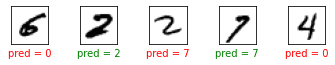

In [14]:
import random as rd

idx = rd.randint(0, len(inputs))
for i in range(idx, idx + 5):
    output = model.forward(inputs[i])
    pred = output.index(max(output))
    gt = targets[i].argmax()
    plt.subplot(5, 5, i%5+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('pred = {}'.format(pred), color = 'g' if pred == gt else 'r')
    plt.imshow(inputs[i].reshape([28,28]), cmap = 'binary')
import random as rd
acc = 0
idx = 0
length = 10000
for i in range(idx, length):
    output = model.forward(inputs[i])
    pred = output.index(max(output))
    gt = targets[i].argmax()
    if gt == pred:
        acc +=1
    if (i + 1) % 1000 == 0:
        percent = ("{0:." + str(1) + "f}").format(100 * (acc / (i+1)))
        printProgressBar(i+1, length, prefix=f'{i+1} / {length}:',
                                     suffix=f'Complete - Acc: {percent}%', length=50)
percent = ("{0:." + str(1) + "f}").format(100 * (acc / float(length)))
print(f'{acc} true / {length} total')
print(f'Acc: {percent}%')

# Reload Model after saved

In [10]:

# TODO fix reload model
new_model = Model(loss='categorical_crossentropy', early_stopping_callback=early_stopping, epoch_end_callback=epoch_end_callback)
new_model.load_model('mnist_model.any_extensions')
# learning_rate = 0.0001
# new_model.train(inputs[0:60000], targets[0:60000], epochs, learning_rate)

SyntaxError: invalid syntax (<string>, line 1)